# **BMI Prediction From Human Photograph**
---




In [2]:
%cd /content
!git clone https://github.com/atoms18/BMI-prediction-from-Human-Photograph.git

/content
Cloning into 'BMI-prediction-from-Human-Photograph'...
remote: Enumerating objects: 4438, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 4438 (delta 16), reused 25 (delta 5), pack-reused 4396
Receiving objects: 100% (4438/4438), 342.69 MiB | 37.34 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (4232/4232), done.


In [3]:
!pip install ninja
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd /content/Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd /content

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.4 MB/s eta 0:00:00
Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 9.62 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Self-Correction-Human-Parsing
/content


In [4]:
!pip install livelossplot

In [5]:

import cv2
import time
import gdown
import numpy
import pandas

from pathlib import Path
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import KFold

import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

input_shape = (224, 224, 3)

## 1.Gathering Data

Datasets contains total of 2,272 images but consider as outlier 444 images so there is 1,828 images available for training and testing.

Sources:
*   Half of the data collectd from *The Photographic Height-Weight Chart* (www.height-weight-chart.com/heightweight.html) via python script.
*   Other half is celebrity body image download via python sctipt by recognites celebrity's name from their face which get from a paper "*Show me your face and I will tell you your height, weight and body mass index*" (https://hal.inria.fr/hal-01799574/document) and use their name to download their body image from Google Images.
*   A small data from *Face-to-height-weight-BMI-estimation* by abhaymise. (https://github.com/abhaymise/Face-to-height-weight-BMI-estimation-)

A data we have got is measured in Imperial system so we use:
\begin{equation}
BMI = \frac{Pound * 703}{(Foot * 12 + Inch)^2}
\end{equation}
To produce a BMI of each images.

/content/BMI-prediction-from-Human-Photograph
Total of datasets: 2997
Mean of BMI: 26.337912806173826
standard Deviation of BMI: 14.902368235775398


,image_filename,weight,foot,inch,bmi
0,WF29.png,112.848506,4.583333,5,22.036806
1,BF73.png,148.492176,5.000000,5,24.707692
2,AM238_old-WM4.png,143.961593,4.583333,5,28.112500
3,AM248_old-WM194.png,161.066856,4.958333,5,27.217114
4,WM103-BM6.png,182.656472,5.208333,5,28.182716
...,...,...,...,...,...
2992,197_00030.png,55.199147,3.083333,5,21.998299
2993,29_00210.png,115.113798,4.875000,5,20.069440
2994,43_00150.png,144.146515,4.958333,5,24.357911
2995,539_00120.png,6.426031,0.541667,5,34.158790


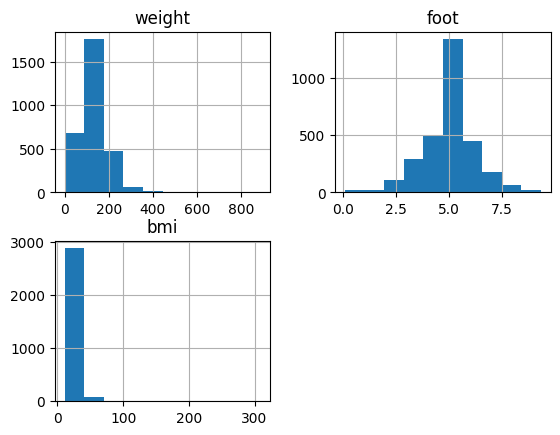

In [ ]:


%cd /content/BMI-prediction-from-Human-Photograph

hwcd_df = pandas.read_csv("/content/data_train (1).csv")

df = hwcd_df
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2

foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()
print(f"Total of datasets: {len(bmi.index)}")
print(f"Mean of BMI: {bmi.mean()}")
print(f"standard Deviation of BMI: {bmi.std()}")

df.assign(bmi=bmi)



/content/BMI-prediction-from-Human-Photograph


<ipython-input-20-e3acfd139211>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = hwcd_df.append(celeb_df, ignore_index=True)
<ipython-input-20-e3acfd139211>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_train_df, ignore_index=True)


Total of datasets: 5269
Mean of BMI: 26.44634602300921
standard Deviation of BMI: 12.061359886957536


,image_filename,weight,foot,inch,bmi
0,410-090-0.png,90.000000,4.000000,10,18.807967
1,410-090-1.png,90.000000,4.000000,10,18.807967
2,410-090-2.png,90.000000,4.000000,10,18.807967
3,410-090-3.png,90.000000,4.000000,10,18.807967
4,410-090-4.png,90.000000,4.000000,10,18.807967
...,...,...,...,...,...
5264,197_00030.png,55.199147,3.083333,5,21.998299
5265,29_00210.png,115.113798,4.875000,5,20.069440
5266,43_00150.png,144.146515,4.958333,5,24.357911
5267,539_00120.png,6.426031,0.541667,5,34.158790


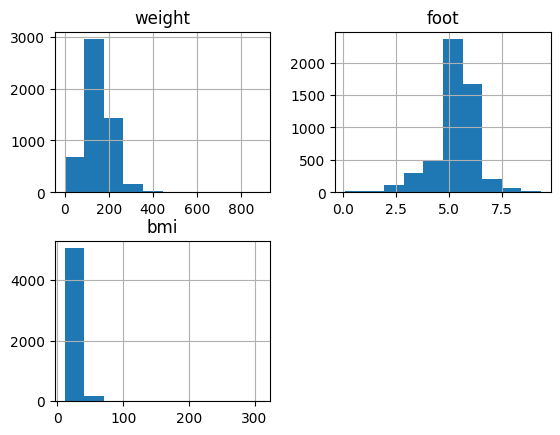

In [ ]:


%cd /content/BMI-prediction-from-Human-Photograph

data_train_df = pandas.read_csv('/content/data_train (1).csv')
hwcd_df = pandas.read_csv("height-weight-chart_dataset.csv")
celeb_df = pandas.read_csv("celeb_datasets.csv")
df = hwcd_df.append(celeb_df, ignore_index=True)
df = df.append(data_train_df, ignore_index=True)
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2
# print('bmi:', bmi[bmi > 40])
# print('df_display:', df_display.iloc[209,:])

foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()
print(f"Total of datasets: {len(bmi.index)}")
print(f"Mean of BMI: {bmi.mean()}")
print(f"standard Deviation of BMI: {bmi.std()}")

df.assign(bmi=bmi)



## 2.Preparing the data

We are preparing the data by using *Self Correction for Human Parsing* (https://github.com/PeikeLi/Self-Correction-Human-Parsing) by only extract a human body from raw dataset which the result of this model has shown below.
<table>
  <tr>
    <td>
      Original Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=11oqtX5cPf5xCU2IvYBLVFs5sqnMlfm5T" width="200">
    </td>
    <td>
      Preprocessed Image using a model:<br>
      <img src="https://drive.google.com/uc?export=view&id=1ydyIAvFcoIlAxyUago_ZkJuyfSXjEooC" width="200">
    </td>
  </tr>
</table>

And we use a preprocessed image as a filter to get rid of the background by convert all of its colors pixel to 1 and multiply them to original image.

<table>
  <tr>
    <td>
      Filter Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=18rjY14s3a_i9tYWXGR-FOLu0PJ2LpkvG" width="200">
    </td>
    <td>
      Labeled Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=1Bqf6gtkBdL8xhsP8hEXcMDeHMVyiu_k4" width="200" height="273">
    </td>
  </tr>
</table>

Then we resize a labeled image to 244 x 244 x 3 to suit the Resnet152 recommend input tensor.


In [ ]:
import time

# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = 'raw_datasets/' + image_filename + ".jpg"
    preprocessed_filepath = 'raw_datasets_preprocessed/' + image_filename + ".png"
    if not Path(raw_filepath).is_file():
      raw_filepath = 'celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = 'celeb_datasets_preprocessed/' + image_filename + ".png"

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break
      img_tmp = raw_img * preprocessed_img

      a1, a2 = img_tmp.shape[:2]
      # print("Raw shape: " + str(img_tmp.shape[:2]))
      biga = max(a1, a2)
      reshape_image = resizeAndPad(img_tmp, (biga, biga), 255)
      # print("shape:", reshape_image.shape[:2])
      reshape_image = cv2.resize(reshape_image, (input_shape[0], input_shape[1]))

      X.append(reshape_image)
      Y.append(y.iloc[i])
      # print("shape2:", reshape_image.shape[:2])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return [X, Y]

start = time.perf_counter()
X, Y = preprocess_df(df, bmi)
print(X, Y)
end = time.perf_counter()
print(f"{end - start:.2f} seconds process time")

[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
 

In [ ]:
import time
# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  empty_img = 0
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = '/content/inputs/train/' + image_filename + ".png"
    preprocessed_filepath = '/content/Self-Correction-Human-Parsing/kaggle/working/outputs/train/' + image_filename + ".png"
    if not Path(raw_filepath).is_file() or not Path(preprocessed_filepath).is_file():
      raw_filepath = '/content/BMI-prediction-from-Human-Photograph/celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = '/content/BMI-prediction-from-Human-Photograph/celeb_datasets_preprocessed/' + image_filename + ".png"
      if not Path(raw_filepath).is_file() or not Path(preprocessed_filepath).is_file():
        raw_filepath = '/content/BMI-prediction-from-Human-Photograph/raw_datasets/' + image_filename + ".jpg"
        preprocessed_filepath = '/content/BMI-prediction-from-Human-Photograph/raw_datasets_preprocessed/' + image_filename + ".png"
        if not Path(raw_filepath).is_file() or not Path(preprocessed_filepath).is_file():
          empty_img += 1
          print("not Path(raw_filepath).is_file()", raw_filepath)

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break
      img_tmp = raw_img * preprocessed_img

      a1, a2 = img_tmp.shape[:2]
      # print("Raw shape: " + str(img_tmp.shape[:2]))
      biga = max(a1, a2)
      reshape_image = resizeAndPad(img_tmp, (biga, biga), 255)
      # print("shape:", reshape_image.shape[:2])
      reshape_image = cv2.resize(reshape_image, (input_shape[0], input_shape[1]))

      X.append(reshape_image)
      Y.append(y.iloc[i])
      # print("shape2:", reshape_image.shape[:2])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return [X, Y, empty_img]


start = time.perf_counter()
X, Y, empty_img = preprocess_df(df, bmi)
print(X, Y)
end = time.perf_counter()

print("Number of imgs are empty:", empty_img)
print(f"{end - start:.2f} seconds process time")

[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
 

### Data Normalization and Augmentation

We use ImageDataGenerator to normalize a labeled and to be augmented by rotating, shifting and horizontal flipling.

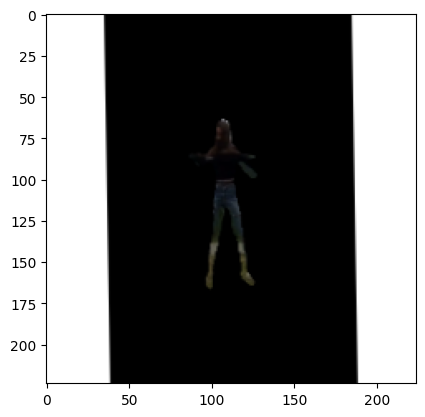

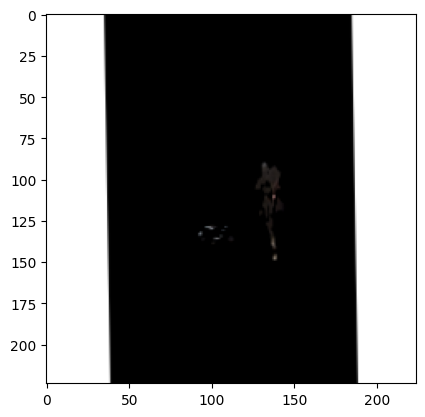

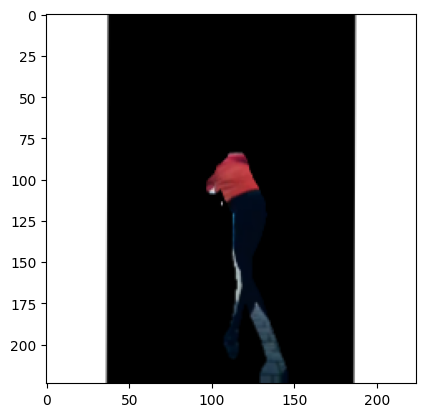

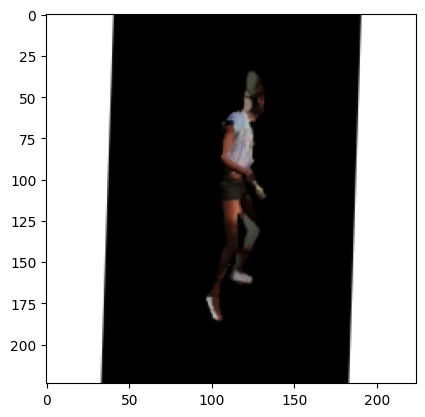

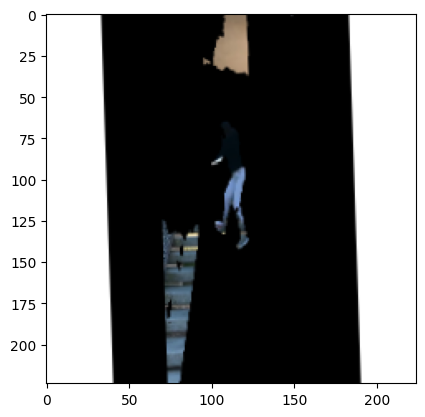

In [ ]:

train_datagen = image.ImageDataGenerator(
  samplewise_center=True,
  rotation_range=2,
  width_shift_range=0.02,
  # height_shift_range=0.02,
  # shear_range=0.02,
  # zoom_range=0.02,
  horizontal_flip=True
)
j = 0
for batch in train_datagen.flow(X, batch_size=5):
  for b in batch:
    plt.figure(j)
    plt.imshow(image.array_to_img(b))
    j += 1
  break

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

## 3.Choosing a model

* From the experiments, we decide to use ResNet152 for the best results.
* We use pre-trained weight called "imagenet" to initialize a model.
* By using it, we mean that we use it for extract a feature of human from an image so we freeze an entire model and feed an output to Fully-Connected Layer.
* A Fully-Connected Layer contains 256 neurons and using ReLu function as activation function.
* We use dropout layer with probability 0.25
* An output layer consist of only one neuron which uses linear activation function.


<img src="https://drive.google.com/uc?export=view&id=1u20brFPULhqItLZCa1zrmiHkaNKtqvMX" width="450">

In [6]:
base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)

base_model.trainable = False
base_model.summary()

234698864/234698864 [==============================] - 2s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                   

### Extract Features

* We use k-fold cross validation to train a model by we choose k=5 and in the meanwhile, we do a features extraction before initialize our own model.
* We keep all 5 fold in the list called train_features, train_labels, test_features and test_labels for not to repeated it.

In [ ]:
batch_size=16
def extract_features(x, y, sample_count, datagen):
    features = numpy.zeros(shape=(sample_count, 2048))
    labels = numpy.zeros(shape=(sample_count))
    generator = datagen.flow(
        x, y,
        batch_size=batch_size
    )
    total = 0
    left_index = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        gap = features_batch.shape[0]
        total += gap
        gap_diff = total - sample_count
        gap_diff = gap_diff if gap_diff > 0 else 0
        features[left_index : left_index + (gap-gap_diff)] = features_batch[0:gap-gap_diff]
        labels[left_index : left_index + (gap-gap_diff)] = labels_batch[0:gap-gap_diff]
        left_index += gap
        if total >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features = [None]*5
train_labels = [None]*5
test_features = [None]*5
test_labels = [None]*5

k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]

  print(f"Extract features from fold number {k+1}")
  start = time.perf_counter()
  train_features[k], train_labels[k] = extract_features(X_train, Y_train, 2000, datagen=train_datagen)
  test_features[k], test_labels[k] = extract_features(X_test, Y_test, 2000, datagen=test_datagen)
  end = time.perf_counter()
  print(f"Finished with {end - start:.2f} seconds process time")
  k += 1

Extract features from fold number 1
1/1 [==============================] - 0s 34ms/step
Finished with 79.76 seconds process time
Extract features from fold number 2
1/1 [==============================] - 0s 39ms/step
Finished with 71.28 seconds process time
Extract features from fold number 3
1/1 [==============================] - 0s 38ms/step
Finished with 73.65 seconds process time
Extract features from fold number 4
1/1 [==============================] - 0s 35ms/step
Finished with 72.48 seconds process time
Extract features from fold number 5
1/1 [==============================] - 0s 36ms/step
Finished with 70.68 seconds process time


## 4.Training
* Optimizer: The stochastic gradient descent (SGD) algorithm.
* Learning Rate: Start from 1e-5 and then we use the learning rate decay policy, which is implemented as follows:
\begin{equation}
LR = LR_{Base} (1 + \gamma * epoch)^{-power}
\end{equation}
where γ is 0.001 and power is 0.75. We use a momentum of 0.9
* Loss function: Huber function
* Metrics: Huber, Mean Absolute Error and R Squared

In [7]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lr_scheduler(epoch, lr):
   return 1e-5 * (1 + 0.001 * epoch) ** (-0.75)

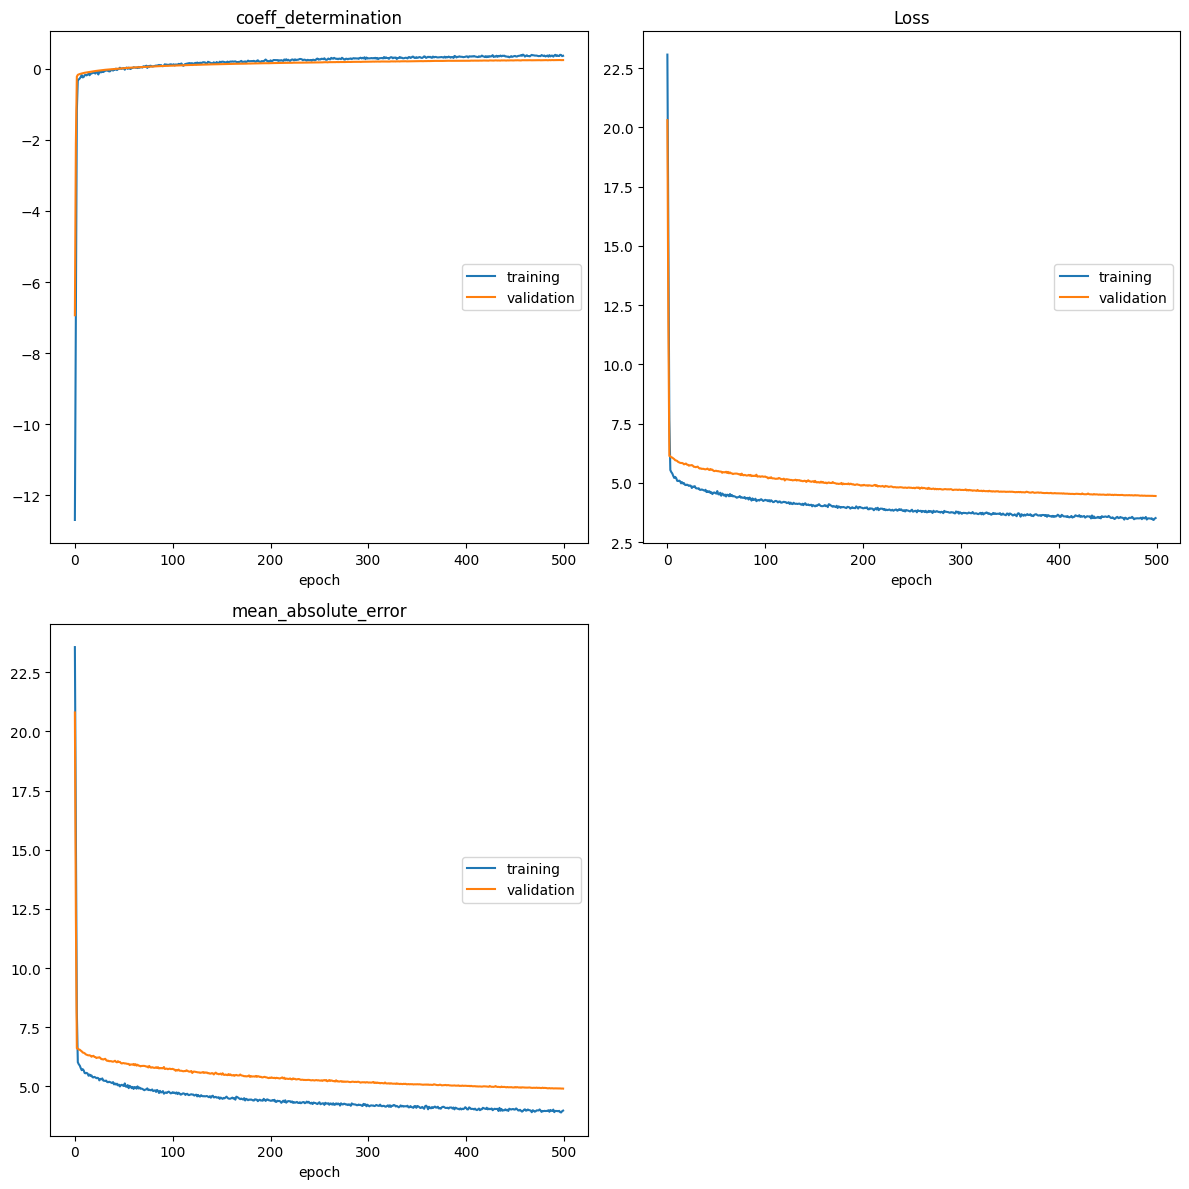

coeff_determination
	training         	 (min:  -12.696, max:    0.400, cur:    0.366)
	validation       	 (min:   -6.935, max:    0.247, cur:    0.245)
Loss
	training         	 (min:    3.437, max:   23.067, cur:    3.517)
	validation       	 (min:    4.447, max:   20.303, cur:    4.447)
mean_absolute_error
	training         	 (min:    3.895, max:   23.567, cur:    3.974)
	validation       	 (min:    4.903, max:   20.803, cur:    4.903)
63/63 - 1s - loss: 3.5171 - mean_absolute_error: 3.9738 - coeff_determination: 0.3661 - val_loss: 4.4469 - val_mean_absolute_error: 4.9035 - val_coeff_determination: 0.2453 - lr: 7.3816e-06 - 976ms/epoch - 15ms/step
63/63 [==============================] - 0s 2ms/step - loss: 4.4469 - mean_absolute_error: 4.9035 - coeff_determination: 0.2453


In [ ]:

%cd /content/Self-Correction-Human-Parsing


VALIDAITON_LOSS = []

for j in range(5):
  model = Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=2048))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(1, activation='linear'))

  model.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
  ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  history = model.fit(train_features[j], train_labels[j], epochs=500,
    validation_data=(test_features[j], test_labels[j]),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )
  model.save(f"last_model{j}.h5")

  results = model.evaluate(test_features[j], test_labels[j])
  VALIDAITON_LOSS.append(results)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0, 25])
# plt.show()

# history = model.fit(train_datagen.flow(x_train, y_train, batch_size=16),
#                     epochs=1000,
#                     validation_data=test_datagen.flow(x_test, y_test, batch_size=32),
#                     verbose=2,
#                     callbacks=[
#                           PlotLossesKeras(),
#                           keras.callbacks.LearningRateScheduler(lr_scheduler),
#                           # keras.callbacks.EarlyStopping(
#                           #     monitor='val_loss',
#                           #     patience=5,
#                           #     restore_best_weights=True
#                           # )
#                     ]
# )



## 5.Evaluate

[Huber loss, MAE, R Squared] of all 5-folds

In [ ]:
VALIDAITON_LOSS


[[3.864993095397949, 4.324265480041504, 0.3783636689186096],
 [3.0171282291412354, 3.4684226512908936, 0.40222829580307007],
 [3.212751626968384, 3.6725451946258545, 0.38586297631263733],
 [3.544801950454712, 4.001404762268066, 0.35315778851509094],
 [4.4469099044799805, 4.903496742248535, 0.245313361287117]]

## 6.Test with your photo!

We have selected the best model which MAE is equal to 4.053

In [ ]:
%cd /content/Self-Correction-Human-Parsing
atr_dataset_url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
gdown.download(atr_dataset_url, 'checkpoints/atr.pth', quiet=False)
# !gdown --id 18L5U8oM9eovBGN48NKkMoSpRaesb-nUh

/content/Self-Correction-Human-Parsing
Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP 



In [ ]:
import cv2
import numpy as np

def resizeAndPad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1:  # horizontal image
        new_w = sw
        new_h = np.round(new_w / aspect).astype(int)
        pad_vert = (sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1:  # vertical image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = (sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else:  # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        padColor = [padColor] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT,
                                    value=padColor)
    # print(h_img.shape[:2])
    return scaled_img

In [ ]:
%cd /content/Self-Correction-Human-Parsing/inputs
from google.colab import files
uploaded = files.upload()

/content/Self-Correction-Human-Parsing/inputs


Saving tam32.png to tam32.png


In [ ]:
print(uploaded)

{'tam32.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x016\x00\x00\x02\x95\x08\x02\x00\x00\x00\xca\xbeP#\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x12t\x00\x00\x12t\x01\xdef\x1fx\x00\x00\xff\xa5IDATx^\xec\x9d\x07\xa0\\U\xb5\xfe\xe7\xf6\xde\xd2{!tP\x8a\x88\xbd\xffU\x9e\xe5\xf9,\xef\xf9\x9e\xef)$wf\xce9\xd3nI\xa1\x83H\x11E\x9a(]\xa4\x08"]z\x17\x08\xa4\xf7\xdc\x96\xdb{\x9b>\xa7\xd7\xfd_k\x9f3\x93{o\x12\x08\t\xc4\x80\xf3\xf99L\xa6\x9c\x99\xbb\xcf\xfe\xcdZ{\x9f]\\\xd6\x81E\xb2\xca*\xab#(\x80\xce0\x0cM\xd3dY\x16\x04\xa1\xa5\xa5\xe5\xa9\xa7\x9e\xca"\x9aUVG\x8b\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0\xcb"\x9aUVG\xaf\x00\xba,\xa2Yeu\xf4\n\xa0

In [ ]:
import os
from PIL import Image

%cd /content/Self-Correction-Human-Parsing

input_filename = Path(next(iter(uploaded))).stem
reshape_image = cv2.imread("inputs/" +  next(iter(uploaded)))
x1, x2 = reshape_image.shape[:2]
print("Raw shape: " + str(reshape_image.shape[:2]))
big = max(x1, x2)
reshape_image = resizeAndPad(reshape_image, (big, big), 255)
path_input = "inputs/" +  next(iter(uploaded))
cv2.imwrite(path_input, reshape_image)
print("Raw shape2: " + str(reshape_image.shape[:2]))

/content/Self-Correction-Human-Parsing
Raw shape: (661, 310)
Raw shape2: (661, 661)


In [ ]:
input_filename = Path(next(iter(uploaded))).stem
test_shape = cv2.imread("inputs/" +  next(iter(uploaded)))
print(next(iter(uploaded)))
print("Raw shape: " + str(test_shape.shape[:2]))

tam32.png
Raw shape: (661, 661)


/content/Self-Correction-Human-Parsing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 1/1 [00:00<00:00,  1.98it/s]
188 / 188
8001 / 188 ** 2 = 0.2942875735626981


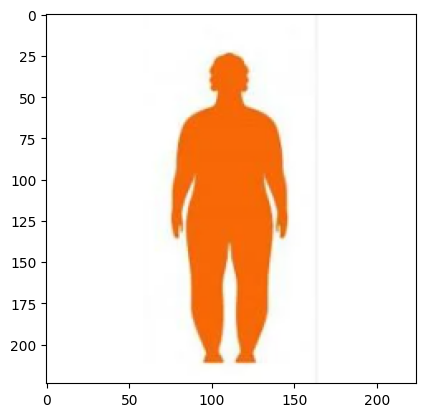

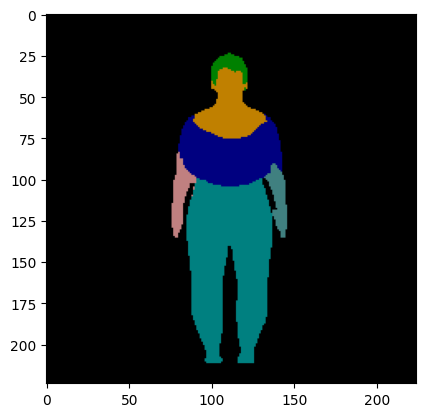

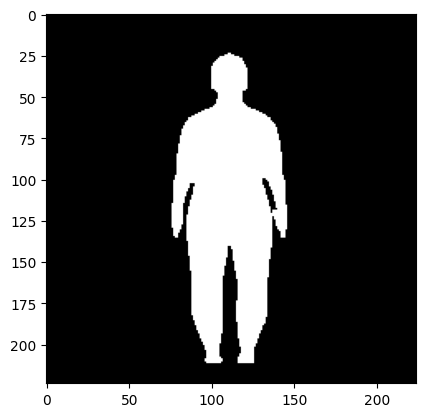

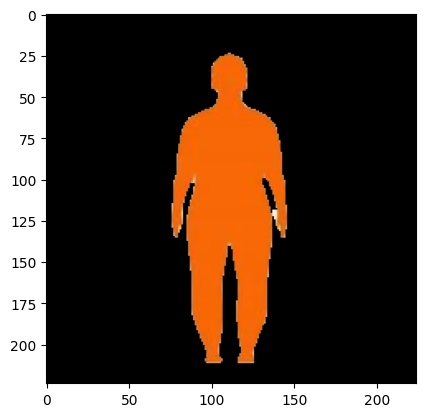

In [ ]:
%cd /content/Self-Correction-Human-Parsing
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir 'inputs' --output-dir 'outputs'

input_filename = Path(next(iter(uploaded))).stem

raw_input_image = cv2.imread("inputs/" +  next(iter(uploaded)))
raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
# print("Raw shape: " + str(raw_input_image.shape[:2]))
raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
# print("Raw shape 2: " + str(raw_input_image.shape[:2]))
plt.figure(0)
plt.imshow(raw_input_image)

preprocessed_input_image = image.load_img("outputs/" +  input_filename + ".png", target_size=input_shape)
preprocessed_input_image = image.img_to_array(preprocessed_input_image)
plt.figure(1)
plt.imshow(preprocessed_input_image.astype(int))

plt.figure(2)
preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
plt.imshow(preprocessed_input_image)

plt.figure(3)
final_input_image = raw_input_image * preprocessed_input_image
plt.imshow(final_input_image.astype(int))


In [ ]:

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

generator = test_datagen.flow(
    numpy.expand_dims(final_input_image, axis=0),
    batch_size=1
)
features_batch = base_model.predict(generator)

dependencies = {
    'coeff_determination': coeff_determination
}
model = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model0.h5', custom_objects=dependencies)
preds = model.predict(features_batch)
bmi_pred = preds[0][0]
print(f"BMI: {bmi_pred}")
model2 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model1.h5', custom_objects=dependencies)
preds2 = model2.predict(features_batch)
bmi_pred = preds2[0][0]
print(f"BMI: {bmi_pred}")
model3 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model2.h5', custom_objects=dependencies)
preds3 = model3.predict(features_batch)
bmi_pred = preds3[0][0]
print(f"BMI: {bmi_pred}")
model4 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model3.h5', custom_objects=dependencies)
preds4 = model4.predict(features_batch)
bmi_pred = preds4[0][0]
print(f"BMI: {bmi_pred}")
model5 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/3.935_model.h5', custom_objects=dependencies)
preds5 = model5.predict(features_batch)
bmi_pred = preds5[0][0]
print(f"BMI: {bmi_pred}")
# model6 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.396_model.h5', custom_objects=dependencies)
# preds6 = model6.predict(features_batch)
# bmi_pred = preds6[0][0]
# print(f"BMI: {bmi_pred}")
# model7 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.471_model.h5', custom_objects=dependencies)
# preds7 = model7.predict(features_batch)
# bmi_pred = preds7[0][0]
# print(f"BMI: {bmi_pred}")

if bmi_pred < 15:
  print("Very severely underweight")
elif 15 <= bmi_pred < 16:
  print("Severely underweight")
elif 16 <= bmi_pred < 18.5:
  print("Underweight")
elif 18.5 <= bmi_pred < 25:
  print("Normal")
elif 25 <= bmi_pred < 30:
  print("Overweight")
elif 30 <= bmi_pred < 35:
  print("Moderately obese")
elif 35 <= bmi_pred < 40:
  print("Severely obese")
elif bmi_pred >= 40:
  print("Very severely obese")



1/1 [==============================] - 0s 47ms/step
BMI: 20.769500732421875
1/1 [==============================] - 0s 61ms/step
BMI: 22.25194549560547
1/1 [==============================] - 0s 68ms/step
BMI: 20.451290130615234
1/1 [==============================] - 0s 53ms/step
BMI: 24.15626335144043
1/1 [==============================] - 0s 54ms/step
BMI: 29.444555282592773
Overweight


**References**
<p>- Self-Correction for Human Parsing (https://arxiv.org/pdf/1910.09777.pdf)</p>
<p>- Show me your face and I will tell you your height,
weight and body mass index (https://hal.inria.fr/hal-01799574/document)</p>
<p>- Estimation of Body Mass Index from
Photographs using Deep Convolutional Neural
Networks (https://arxiv.org/pdf/1908.11694v1.pdf)</p>


# **Thêm customer datasets cho phần 1.Gathering Data**
**Tải 2 tập data gồm 2615 + 726 = 3341 ảnh, trong đó lấy 3000 ảnh làm train và 341 ảnh làm val**

In [9]:
import gdown
%cd /content
!gdown --id 1Ysk6Ncef72Sbf8HvLMJE3yhQHkopPiQL

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Ysk6Ncef72Sbf8HvLMJE3yhQHkopPiQL 



In [ ]:
%cd /content
!gdown --id 12H1BLY75GrmrCP4fGk_CNrVPSxUGnS2K

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=12H1BLY75GrmrCP4fGk_CNrVPSxUGnS2K 



In [ ]:
!tar -xvf /content/full-body-tiktok-dancing-DatasetNinja.tar

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
ds/ann/349_00030.png.json
ds/ann/177_00300.png.json
ds/ann/530_00210.png.json
ds/ann/133_00420.png.json
ds/ann/429_00060.png.json
ds/ann/106_00300.png.json
ds/ann/216_00360.png.json
ds/ann/599_00300.png.json
ds/ann/756_00120.png.json
ds/ann/612_00120.png.json
ds/ann/320_00300.png.json
ds/ann/106_00270.png.json
ds/ann/342_00210.png.json
ds/ann/714_00420.png.json
ds/ann/19_00360.png.json
ds/ann/357_00420.png.json
ds/ann/674_00210.png.json
ds/ann/235_00120.png.json
ds/ann/77_00120.png.json
ds/ann/40_00150.png.json
ds/ann/169_00090.png.json
ds/ann/150_00060.png.json
ds/ann/716_00120.png.json
ds/ann/489_00180.png.json
ds/ann/652_00060.png.json
ds/ann/459_00300.png.json
ds/ann/65_00360.png.json
ds/ann/612_00150.png.json
ds/ann/357_00270.png.json
ds/ann/150_00210.png.json
ds/ann/539_00210.png.json
ds/ann/141_00150.png.json
ds/ann/753_00330.png.json
ds/ann/180_00120.png.json
ds/ann/24_00150.png.json
ds/ann/717_00120.png.json
ds/ann/644_0

In [ ]:
!unzip /content/full_body_photo_database.zip

Archive:  /content/full_body_photo_database.zip
   creating: full_body_photo_database/
  inflating: __MACOSX/._full_body_photo_database  
  inflating: full_body_photo_database/.DS_Store  
  inflating: __MACOSX/full_body_photo_database/._.DS_Store  
  inflating: full_body_photo_database/codebook.pdf  
  inflating: __MACOSX/full_body_photo_database/._codebook.pdf  
   creating: full_body_photo_database/photos/
  inflating: __MACOSX/full_body_photo_database/._photos  
   creating: full_body_photo_database/rating data/
  inflating: __MACOSX/full_body_photo_database/._rating data  
  inflating: full_body_photo_database/photos/BM29-BM33.png  
  inflating: __MACOSX/full_body_photo_database/photos/._BM29-BM33.png  
  inflating: full_body_photo_database/photos/WF73.png  
  inflating: __MACOSX/full_body_photo_database/photos/._WF73.png  
  inflating: full_body_photo_database/photos/AM207-WM114.png  
  inflating: __MACOSX/full_body_photo_database/photos/._AM207-WM114.png  
  inflating: full_body_

In [ ]:
import os
!mkdir /content/inputs
!mkdir /content/inputs/train
!mkdir /content/inputs/val

files1 = os.listdir('/content/full_body_photo_database/photos')
files2 = os.listdir('/content/ds/img')
for name1 in files1:
  image1 = cv2.imread('/content/full_body_photo_database/photos/' + name1)
  cv2.imwrite('/content/inputs/train/' + name1, image1)
for i, name2 in enumerate(files2):
  image2 = cv2.imread('/content/ds/img/' + name2)
  if i < 341:
    cv2.imwrite('/content/inputs/val/' + name2, image2)
  else:
    cv2.imwrite('/content/inputs/train/' + name2, image2)

In [ ]:
import os
files = os.listdir('/content/inputs/train/')
print(len(files))

3341


**Tiến hành tạo dữ liệu cho Gathering data**

In [ ]:
import os
from PIL import Image

path_imgs = '/content/inputs/train' + '/'
name_imgs = os.listdir(path_imgs)
for name_img in name_imgs:
  path_img = path_imgs + name_img
  print("Path:", path_img)
  imageN = cv2.imread(path_img)
  x1, x2 = imageN.shape[:2]
  print("Raw shape: " + str(imageN.shape[:2]))
  big = max(x1, x2)
  imageN = resizeAndPad(imageN, (big, big), 255)
  cv2.imwrite(path_img, imageN)
  print("Last shape: " + str(imageN.shape[:2]))

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /content/inputs/train/716_00150.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/86_00030.png
Raw shape: (1024, 576)
Last shape: (1024, 1024)
Path: /content/inputs/train/263_00090.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/11_00240.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/BM106.png
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /content/inputs/train/374_00390.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/48_00120.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/BF43-BF55.png
Raw shape: (1620, 2430)
Last shape: (2430, 2430)
Path: /content/inputs/train/106_00030.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/206_00300.png
Raw shape: (960, 540)
Last shape: (960, 960)
Path: /content/inputs/train/

In [ ]:
%mkdir /content/outputs
%mkdir /content/outputs/train
%mkdir /content/outputs/val
%cd /content/Self-Correction-Human-Parsing
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir '/content/inputs/train' --output-dir '/content/outputs/train'


mkdir: cannot create directory ‘/content/outputs’: File exists
mkdir: cannot create directory ‘/content/outputs/train’: File exists
mkdir: cannot create directory ‘/content/outputs/val’: File exists
/content/Self-Correction-Human-Parsing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 3000/3000 [38:37<00:00,  1.29it/s]


In [ ]:
import csv

data_csv = [['image_filename', 'weight', 'foot', 'inch']]
cnt = 0

name_preprocessed_images = os.listdir('/content/outputs/train')
for name in name_preprocessed_images:
  preprocessed_input_image = image.load_img('/content/outputs/train/' + name, target_size=input_shape)
  preprocessed_input_image = image.img_to_array(preprocessed_input_image)
  # plt.figure(0)
  # plt.imshow(preprocessed_input_image.astype(int))

  # plt.figure(1)
  preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
  preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
  preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
  # plt.imshow(preprocessed_input_image)
  img_bin = preprocessed_input_image
  sum_h_large = 0
  sum_h_small = 0
  sum_h = 0
  sum_w = 0
  for i in img_bin:
    sum_wh = 0
    for k in i:
      if np.all(k > 0):
        sum_wh += 1
    if sum_wh != 0:
      sum_h_large += 1
      sum_h += 1
      sum_w += sum_wh
    else:
      sum_h_small = max(sum_h_large, sum_h_small)
      sum_h_large = 0
    # print(sum_wh)
  max_h = max(sum_h_large, sum_h_small)
  # print(name, max_h, "/", sum_h)
  sum_w *= 130
  if max_h == 0:
    print(name, max_h, "/", sum_h)
    continue
  # print(sum_w, "/", max_h, "** 2 =", sum_w / max_h ** 2)
  feet = (max_h - 10) / 12 / 2
  wei = sum_w / 703 / 4
  data_csv.append([name, str(wei), str(feet), '5'])
  print(name, wei, "* 703 / (", feet, "* 12 + 5) ** 2 =", wei * 703 / (feet * 12 + 5) ** 2)
  cnt += 1
  print(cnt, "/ 3000")

with open('/content/data_train.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_csv)
    print("Write done!")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
367_00120.png 134.76173541963016 * 703 / ( 4.666666666666667 * 12 + 5) ** 2 = 25.460225745767268
501 / 3000
145_00300.png 212.98364153627313 * 703 / ( 6.333333333333333 * 12 + 5) ** 2 = 22.820835238530712
502 / 3000
111_00360.png 202.1194879089616 * 703 / ( 6.208333333333333 * 12 + 5) ** 2 = 22.481705628733042
503 / 3000
BM66.png 161.76031294452346 * 703 / ( 4.791666666666667 * 12 + 5) ** 2 = 29.11168
504 / 3000
715_00030.png 63.705547652916074 * 703 / ( 3.2916666666666665 * 12 + 5) ** 2 = 22.615831334427472
505 / 3000
512_00150.png 194.58392603129445 * 703 / ( 5.75 * 12 + 5) ** 2 = 24.980368882395908
506 / 3000
BM116.png 135.4551920341394 * 703 / ( 4.791666666666667 * 12 + 5) ** 2 = 24.3776
507 / 3000
WM193-WM23.png 141.55761024182075 * 703 / ( 4.625 * 12 + 5) ** 2 = 27.188033604262
508 / 3000
458_00240.png 152.56045519203414 * 703 / ( 5.458333333333333 * 12 + 5) ** 2 = 21.578391429002565
509 / 3000
BM152.png 134.43812233285917 

In [ ]:
with open('/content/data_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      # if float(row[2]) > 40:
        print(row)

['image_filename', 'weight', 'foot', 'inch']
['BM150.png', '146.31934566145094', '4.666666666666667', '5']
['WM7.png', '130.7859174964438', '4.541666666666667', '5']
['AM248_old-WM194.png', '161.06685633001422', '4.958333333333333', '5']
['BF61-WF72.png', '121.8172119487909', '4.625', '5']
['WM114-BM29.png', '186.67852062588904', '5.083333333333333', '5']
['WF6.png', '134.3918918918919', '4.666666666666667', '5']
['BM159.png', '128.05832147937411', '4.541666666666667', '5']
['BF43-BF14.png', '140.72546230440966', '5.083333333333333', '5']
['WF107.png', '140.9103840682788', '5.041666666666667', '5']
['BM81-WM193.png', '128.6593172119488', '4.291666666666667', '5']
['WM77-BM51.png', '146.6429587482219', '4.625', '5']
['WF12.png', '136.14864864864865', '4.625', '5']
['WF25.png', '146.9203413940256', '4.458333333333333', '5']
['AM213_old-WM64.png', '144.83997155049786', '4.625', '5']
['BM85.png', '126.67140825035563', '4.75', '5']
['WF42.png', '152.83783783783784', '4.708333333333333', '5'

In [ ]:
!zip -r /content/outputs.zip /content/outputs

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/val/ (stored 0%)
  adding: content/outputs/val/45_00150.png (deflated 17%)
  adding: content/outputs/val/102_00060.png (deflated 38%)
  adding: content/outputs/val/751_00090.png (deflated 13%)
  adding: content/outputs/val/603_00360.png (deflated 18%)
  adding: content/outputs/val/401_00270.png (deflated 22%)
  adding: content/outputs/val/244_00330.png (deflated 25%)
  adding: content/outputs/val/112_00390.png (deflated 21%)
  adding: content/outputs/val/440_00120.png (deflated 28%)
  adding: content/outputs/val/257_00090.png (deflated 30%)
  adding: content/outputs/val/215_00150.png (deflated 30%)
  adding: content/outputs/val/737_00120.png (deflated 16%)
  adding: content/outputs/val/529_00690.png (deflated 32%)
  adding: content/outputs/val/337_00030.png (deflated 31%)
  adding: content/outputs/val/54_00390.png (deflated 14%)
  adding: content/outputs/val/168_00150.png (deflated 24%)
  adding: content/outputs/val/152_0

# **Evaluate customer datasets**

In [8]:
%cd /content/
!unrar x '/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/weight_files.rar'

/content

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/weight_files.rar

Creating    weight_files                                              OK
Extracting  weight_files/last_model2_3.468_500eps.h5                       5%  OK 
Extracting  weight_files/last_model2_3.672_500eps.h5                      11%  OK 
Extracting  weight_files/last_model2_4.001_500eps.h5                      16%  OK 
Extracting  weight_files/last_model2_4.324_500eps.h5                      22%  OK 
Extracting  weight_files/last_model2_4.903_500eps.h5                      27%  OK 
Extracting  weight_files/last_model4.058_500eps.h5                        33%  OK 
Extracting  weight_files/last_model4.068_500eps.h5                        38%  OK 
Extracting  weight_files/last_model4.323_500eps.h5                        44%  OK 
Extracti

In [11]:
%cd /content/
!unzip '/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Data/raw_3341imgs.zip'

/content
Archive:  /content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Data/raw_3341imgs.zip
   creating: kaggle/working/inputs/train/
  inflating: kaggle/working/inputs/train/510_00300.png  
  inflating: kaggle/working/inputs/train/691_00060.png  
  inflating: kaggle/working/inputs/train/BM6-BM8.png  
  inflating: kaggle/working/inputs/train/104_00210.png  
  inflating: kaggle/working/inputs/train/BF70-WF3.png  
  inflating: kaggle/working/inputs/train/56_00210.png  
  inflating: kaggle/working/inputs/train/675_00420.png  
  inflating: kaggle/working/inputs/train/298_00300.png  
  inflating: kaggle/working/inputs/train/135_00270.png  
  inflating: kaggle/working/inputs/train/456_00420.png  
  inflating: kaggle/working/inputs/train/415_00360.png  
  inflating: kaggle/working/inputs/train/717_00060.png  
  inflating: kaggle/working/inputs/train/15_00420.png  
  inflating: kaggle/working/inputs/train/213_00120.png  
  inflating: kaggle/working/inputs/train/356_00120.png  
  inflating: 

In [12]:
!unzip '/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/preprocessing_3341imgs_lan2.zip'
!unzip '/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/preprocessing_3341imgs.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: kaggle/working/outputs/train/41_00330.png  
  inflating: kaggle/working/outputs/train/BM81-BM12.png  
  inflating: kaggle/working/outputs/train/751_00390.png  
  inflating: kaggle/working/outputs/train/10_00420.png  
  inflating: kaggle/working/outputs/train/154_00270.png  
  inflating: kaggle/working/outputs/train/BF19-BF49.png  
  inflating: kaggle/working/outputs/train/765_00090.png  
  inflating: kaggle/working/outputs/train/90_00270.png  
  inflating: kaggle/working/outputs/train/530_00090.png  
  inflating: kaggle/working/outputs/train/WF11.png  
  inflating: kaggle/working/outputs/train/515_00270.png  
  inflating: kaggle/working/outputs/train/WM46.png  
  inflating: kaggle/working/outputs/train/3_00300.png  
  inflating: kaggle/working/outputs/train/118_00390.png  
  inflating: kaggle/working/outputs/train/44_00150.png  
  inflating: kaggle/working/outputs/train/711_00180.png  
  inflating: kaggle/working/out

In [16]:
import os
files = os.listdir('/content/kaggle/working/outputs/train')
print(len(files))

3000


Length: 339


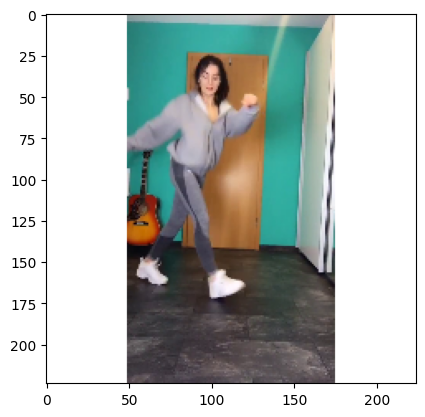

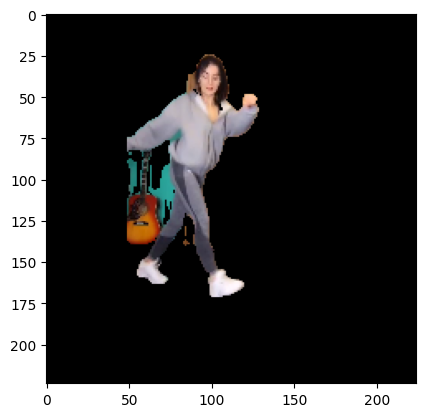

In [18]:
import csv


img_val_list = []
with open('/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/data_val.csv') as csv_val:
    csv_val = csv.reader(csv_val, delimiter=',')
    for i, row in enumerate(csv_val):
        if i == 0:
            continue
#         print(i, row)

        if not Path("/content/kaggle/working/inputs/train/" + row[0]).is_file():
            print("Not file:", "/kaggle/working/inputs/train/" + row[0])
        if not Path("/content/content/outputs/val/" + row[0]).is_file():
            print("Not file:", "/content/content/outputs/val/" + row[0])
        raw_input_image = cv2.imread("/content/kaggle/working/inputs/train/" + row[0])
#         print("Raw shape: " + str(raw_input_image.shape[:2]))
        raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
        raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
        plt.figure(0)
        plt.imshow(raw_input_image)

        preprocessed_input_image = image.load_img("/content/content/outputs/val/" + row[0], target_size=input_shape)
        preprocessed_input_image = image.img_to_array(preprocessed_input_image)

        preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
        preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
        preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1

        plt.figure(3)
        final_input_image = raw_input_image * preprocessed_input_image
        plt.imshow(final_input_image.astype(int))
        img_val_list.append(final_input_image)
print('Length:', len(img_val_list))


In [20]:
accuracy_list = []

for k, model_name in enumerate(os.listdir('/content/weight_files')):
    mean_accuracy = 0
    for i, final_input_image in enumerate(img_val_list):
        test_datagen = image.ImageDataGenerator(
          samplewise_center=True,
        )

        generator = test_datagen.flow(
            numpy.expand_dims(final_input_image, axis=0),
            batch_size=1
        )
        features_batch = base_model.predict(generator)

        dependencies = {
            'coeff_determination': coeff_determination
        }

        model = keras.models.load_model('/content/weight_files/' + model_name, custom_objects=dependencies)
        preds = model.predict(features_batch)
        bmi_pred = preds[0][0]
        bmi_real = float(row[1]) * 703 / (float(row[2]) * 12 + float(row[3])) ** 2
        accuracy = abs(bmi_pred - bmi_real) / bmi_real
        mean_accuracy += accuracy
#         print(f"BMI{k+1}: {bmi_pred}", model_path, accuracy)

        print(i+1, "/ 339")

    accuracy_list.append([mean_accuracy/339, model_name])
    print('Accuracy:', mean_accuracy/339, model_name)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 65ms/step
31 / 339
1/1 [==============================] - 0s 61ms/step
32 / 339
1/1 [==============================] - 0s 59ms/step
33 / 339
1/1 [==============================] - 0s 60ms/step
34 / 339
1/1 [==============================] - 0s 58ms/step
35 / 339
1/1 [==============================] - 0s 58ms/step
36 / 339
1/1 [==============================] - 0s 64ms/step
37 / 339
1/1 [==============================] - 0s 60ms/step
38 / 339
1/1 [==============================] - 0s 60ms/step
39 / 339
1/1 [==============================] - 0s 61ms/step
40 / 339
1/1 [==============================] - 0s 59ms/step
41 / 339
1/1 [==============================] - 0s 59ms/step
42 / 339
1/1 [==============================] - 0s 61ms/step
43 / 339
1/1 [==============================] - 0s 60ms/step
44 / 339
1/1 [==============================] - 0s 58ms/step
45 / 339
1/1 [=======================

In [21]:
for acc in accuracy_list:
    print("Accuracy is", acc[0], "with", acc[1])

Accuracy is 0.4719668612711712 with last_model2_4.903_500eps.h5
Accuracy is 0.5443984295392865 with last_models4.052_500eps.h5
Accuracy is 0.5338629700432893 with last_model5.301_100eps.h5
Accuracy is 0.5867775855862019 with last_models5.394_500eps.h5
Accuracy is 0.5105217513972589 with last_model5.042_100eps.h5
Accuracy is 0.4734584184033702 with last_model4.398_500eps.h5
Accuracy is 0.4973595636787028 with last_model4.058_500eps.h5
Accuracy is 0.5927826343277076 with last_models4.667_500eps.h5
Accuracy is 0.579005862164794 with last_models4.132_500eps.h5
Accuracy is 0.4740263147608615 with last_model2_3.468_500eps.h5
Accuracy is 0.5167983638206961 with last_model2_4.324_500eps.h5
Accuracy is 0.5172489831327169 with last_model5.025_100eps.h5
Accuracy is 0.5552026773697822 with last_models4.016_500eps.h5
Accuracy is 0.475484007351649 with last_model2_3.672_500eps.h5
Accuracy is 0.5115942947693669 with last_model2_4.001_500eps.h5
Accuracy is 0.5115221178853622 with last_model4.732_100ep

In [22]:
with open('/content/drive/MyDrive/20231/CV/FinalReport - Nhóm 4/Codes/BMI/data_val.csv') as csv_val:
    csv_val = csv.reader(csv_val, delimiter=',')
    for i, row in enumerate(csv_val):
        if i == 0:
            continue
        bmi_real = float(row[1]) * 703 / (float(row[2]) * 12 + float(row[3])) ** 2
        print(i, float(row[1]), abs(bmi_real-100))
        print(i, float(row[1]), bmi_real-100)

1 148.26102418207682 78.10806553245116
1 148.26102418207682 -78.10806553245116
2 133.46728307254622 80.00372955405189
2 133.46728307254622 -80.00372955405189
3 260.1849217638691 78.15282630117352
3 260.1849217638691 -78.15282630117352
4 65.78591749644382 74.98783126014061
4 65.78591749644382 -74.98783126014061
5 130.0 79.01974288337925
5 130.0 -79.01974288337925
6 167.58534850640115 83.10265696152605
6 167.58534850640115 -83.10265696152605
7 147.42887624466573 75.46923076923076
7 147.42887624466573 -75.46923076923076
8 95.6045519203414 76.95130315500685
8 95.6045519203414 -76.95130315500685
9 84.78662873399716 79.55932784636488
9 84.78662873399716 -79.55932784636488
10 28.662873399715505 78.33915614082235
10 28.662873399715505 -78.33915614082235
11 97.63869132290185 75.56425774296903
11 97.63869132290185 -75.56425774296903
12 17.197724039829303 52.7734375
12 17.197724039829303 -52.7734375
13 69.16073968705548 79.33042831331703
13 69.16073968705548 -79.33042831331703
14 281.312233285917

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
